<a href="https://colab.research.google.com/github/snghynn/summ/blob/main/%ED%8C%8C%EB%A8%B8%EC%99%84_ch9_6~8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

pg. 591 ~ 624

## 9.6 아이템 기반 최근접 이웃 협업 필터링
- 추천 정확도가 더 뛰어난 아이템 기반의 협업 필터링 구현

### 데이터 가공 및 변환

In [1]:
import pandas as pd
import numpy as np

movies = pd.read_csv('movies.csv')
ratings = pd.read_csv('ratings.csv')
print(movies.shape)
print(ratings.shape)

(9742, 3)
(100836, 4)


- row(행) 레벨 형태의 원본 데이터 세트를 그림과 같이 모든 사용자를 로우로, 모든 영화를 칼럼으로 구성한 데이터 세트로 변경해야 함

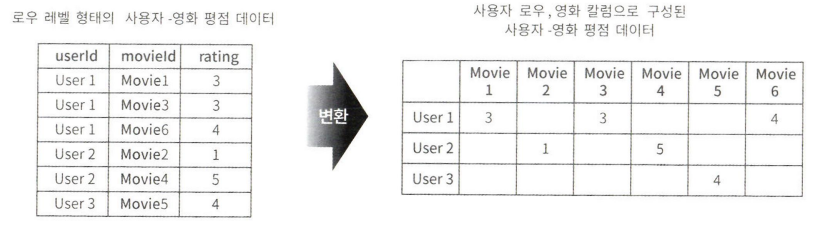

In [2]:
ratings = ratings[['userId','movieId','rating']]
ratings_matrix = ratings.pivot_table('rating', index='userId', columns='movieId')
ratings_matrix.head()

movieId,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
userId,,,,,,,,,,,,,,,,,,,,,
1,4.0,NaN,4.0,NaN,NaN,4.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
# title 컬럼을 얻기 위해 movies와 조인
rating_movies = pd.merge(ratings,movies,on='movieId')
# columns='title'로 title 칼럼으로 피벗 수행
ratings_matrix = rating_movies.pivot_table('rating',index='userId',columns='title')
# NaN 값을 모두 0으로 변환
ratings_matrix = ratings_matrix.fillna(0) # NaN 값은 모두 0으로 변환
ratings_matrix.head()

title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...,Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
userId,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### 영화 간 유사도 산출

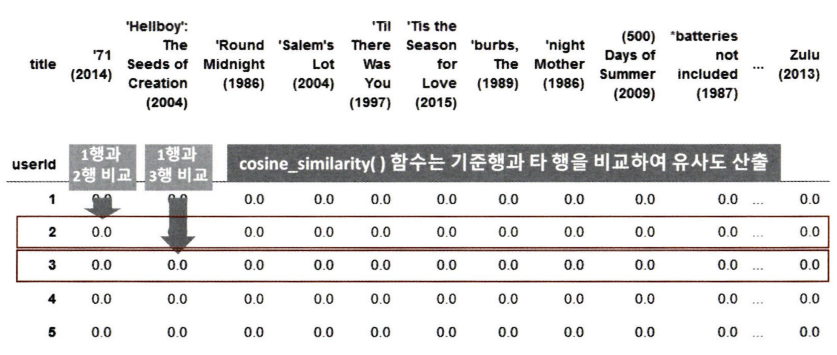

In [4]:
ratings_matrix_T = ratings_matrix.transpose()
ratings_matrix_T.head()

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
title,,,,,,,,,,,,,,,,,,,,,
'71 (2014),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
'Hellboy': The Seeds of Creation (2004),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
'Round Midnight (1986),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
'Salem's Lot (2004),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
'Til There Was You (1997),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
from sklearn.metrics.pairwise import cosine_similarity

item_sim = cosine_similarity(ratings_matrix_T, ratings_matrix_T)

item_sim_df = pd.DataFrame(data=item_sim, index=ratings_matrix.columns, columns=ratings_matrix.columns)
print(item_sim_df.shape)
item_sim_df.head()

(9719, 9719)


title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...,Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
title,,,,,,,,,,,,,,,,,,,,,
'71 (2014),1.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.141653,0.0,...,0.0,0.342055,0.543305,0.707107,0.0,0.0,0.139431,0.327327,0.0,0.0
'Hellboy': The Seeds of Creation (2004),0.0,1.000000,0.707107,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0
'Round Midnight (1986),0.0,0.707107,1.000000,0.000000,0.000000,0.0,0.176777,0.0,0.000000,0.0,...,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0
'Salem's Lot (2004),0.0,0.000000,0.000000,1.000000,0.857493,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0
'Til There Was You (1997),0.0,0.000000,0.000000,0.857493,1.000000,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0


In [6]:
item_sim_df["Godfather, The (1972)"].sort_values(ascending=False)[:6]

title
Godfather, The (1972)                        1.000000
Godfather: Part II, The (1974)               0.821773
Goodfellas (1990)                            0.664841
One Flew Over the Cuckoo's Nest (1975)       0.620536
Star Wars: Episode IV - A New Hope (1977)    0.595317
Fargo (1996)                                 0.588614
Name: Godfather, The (1972), dtype: float64

In [7]:
item_sim_df["Inception (2010)"].sort_values(ascending=False)[1:6]

title
Dark Knight, The (2008)          0.727263
Inglourious Basterds (2009)      0.646103
Shutter Island (2010)            0.617736
Dark Knight Rises, The (2012)    0.617504
Fight Club (1999)                0.615417
Name: Inception (2010), dtype: float64

### 아이템 기반 최근접 이웃 협업 필터링으로 개인화된 영화 추천

In [8]:
def predict_rating(ratings_arr, item_sim_arr):
  ratings_pred = ratings_arr.dot(item_sim_arr)/np.array([np.abs(item_sim_arr).sum(axis=1)])
  return ratings_pred

In [9]:
ratings_pred = predict_rating(ratings_matrix.values, item_sim_df.values)
ratings_pred_matrix = pd.DataFrame(data=ratings_pred, index=ratings_matrix.index, columns=ratings_matrix.columns)
ratings_pred_matrix.head()

title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...,Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
userId,,,,,,,,,,,,,,,,,,,,,
1,0.070345,0.577855,0.321696,0.227055,0.206958,0.194615,0.249883,0.102542,0.157084,0.178197,...,0.113608,0.181738,0.133962,0.128574,0.006179,0.212070,0.192921,0.136024,0.292955,0.720347
2,0.018260,0.042744,0.018861,0.000000,0.000000,0.035995,0.013413,0.002314,0.032213,0.014863,...,0.015640,0.020855,0.020119,0.015745,0.049983,0.014876,0.021616,0.024528,0.017563,0.000000
3,0.011884,0.030279,0.064437,0.003762,0.003749,0.002722,0.014625,0.002085,0.005666,0.006272,...,0.006923,0.011665,0.011800,0.012225,0.000000,0.008194,0.007017,0.009229,0.010420,0.084501
4,0.049145,0.277628,0.160448,0.206892,0.309632,0.042337,0.130048,0.116442,0.099785,0.097432,...,0.051269,0.076051,0.055563,0.054137,0.008343,0.159242,0.100941,0.062253,0.146054,0.231187
5,0.007278,0.066951,0.041879,0.013880,0.024842,0.018240,0.026405,0.018673,0.021591,0.018841,...,0.009689,0.022246,0.013360,0.012378,0.000000,0.025839,0.023712,0.018012,0.028133,0.052315


In [10]:
# 실제 평점과의 차이 비교
from sklearn.metrics import mean_squared_error

def get_mse(pred, actual):
  pred = pred[actual.nonzero()].flatten()
  actual = actual[actual.nonzero()].flatten()
  return mean_squared_error(pred,actual)

print('아이템 기반 모든 최근접 이웃 MSE: ', get_mse(ratings_pred, ratings_matrix.values))

아이템 기반 모든 최근접 이웃 MSE:  9.895354759094706


In [11]:
# 특정 영화와 가장 비슷한 유사도를 가지는 영화에 대해서만 유사도 벡터 적용
def predict_rating_topsim(ratings_arr, item_sim_arr, n=20):
  pred = np.zeros(ratings_arr.shape)

  for col in range(ratings_arr.shape[1]):
    top_n_items = [np.argsort(item_sim_arr[:,col])[:-n-1:-1]]
    for row in range(ratings_arr.shape[0]):
      pred[row,col] = item_sim_arr[col,:][top_n_items].dot(ratings_arr[row,:][top_n_items].T)
      pred[row,col] /= np.sum(np.abs(item_sim_arr[col,:][top_n_items]))

  return pred

In [12]:
ratings_pred = predict_rating_topsim(ratings_matrix.values, item_sim_df.values, n=20)
print('아이템 기반 최근접 TOP-20 이웃 MSE: ', get_mse(ratings_pred,ratings_matrix.values))

ratings_pred_matrix = pd.DataFrame(data=ratings_pred, index=ratings_matrix.index, columns=ratings_matrix.columns)

아이템 기반 최근접 TOP-20 이웃 MSE:  3.6949827608772314


In [13]:
user_rating_id = ratings_matrix.loc[9,:]
user_rating_id[user_rating_id>0].sort_values(ascending=False)[:10]

title
Adaptation (2002)                                                                 5.0
Citizen Kane (1941)                                                               5.0
Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981)    5.0
Producers, The (1968)                                                             5.0
Lord of the Rings: The Two Towers, The (2002)                                     5.0
Lord of the Rings: The Fellowship of the Ring, The (2001)                         5.0
Back to the Future (1985)                                                         5.0
Austin Powers in Goldmember (2002)                                                5.0
Minority Report (2002)                                                            4.0
Witness (1985)                                                                    4.0
Name: 9, dtype: float64

In [14]:
def get_unseen_movies(ratings_matrix, userId):
  user_rating = ratings_matrix.loc[userId,:]
  already_seen = user_rating[user_rating>0].index.tolist()
  movies_list = ratings_matrix.columns.tolist()
  unseen_list = [movie for movie in movies_list if movie not in already_seen]
  return unseen_list

In [15]:
def recomm_movie_by_userid(pred_df, userId, unseen_list, top_n=10):
  recomm_movies = pred_df.loc[userId,unseen_list].sort_values(ascending=False)[:top_n]
  return recomm_movies

unseen_list = get_unseen_movies(ratings_matrix,9)
recomm_movies = recomm_movie_by_userid(ratings_pred_matrix,9,unseen_list,top_n=10)
recomm_movies = pd.DataFrame(data=recomm_movies.values, index=recomm_movies.index, columns=['pred_score'])

recomm_movies

,pred_score
title,
Shrek (2001),0.866202
Spider-Man (2002),0.857854
"Last Samurai, The (2003)",0.817473
Indiana Jones and the Temple of Doom (1984),0.816626
"Matrix Reloaded, The (2003)",0.800990
Harry Potter and the Sorcerer's Stone (a.k.a. Harry Potter and the Philosopher's Stone) (2001),0.765159
Gladiator (2000),0.740956
"Matrix, The (1999)",0.732693
Pirates of the Caribbean: The Curse of the Black Pearl (2003),0.689591


## ch9.7 행렬 분해를 이용한 잠재 요인 협업 필터링 실습

In [16]:
# 확률적 경사 하강법을 이용한 행렬 분해
def get_rmse(R, P, Q, non_zeros):
    error = 0
    # 두개의 분해된 행렬 P와 Q.T의 내적 곱으로 예측 R 행렬 생성
    full_pred_matrix = np.dot(P, Q.T)

    # 실제 R 행렬에서 널이 아닌 값의 위치 인덱스 추출하여 실제 R 행렬과 예측 행렬의 RMSE 추출
    x_non_zero_ind = [non_zero[0] for non_zero in non_zeros]
    y_non_zero_ind = [non_zero[1] for non_zero in non_zeros]
    R_non_zeros = R[x_non_zero_ind, y_non_zero_ind]

    full_pred_matrix_non_zeros = full_pred_matrix[x_non_zero_ind, y_non_zero_ind]

    mse = mean_squared_error(R_non_zeros, full_pred_matrix_non_zeros)
    rmse = np.sqrt(mse)

    return rmse

In [17]:
def matrix_factorization(R, K, steps=200, learning_rate=0.01, r_lambda = 0.01):
    num_users, num_items = R.shape
    # P와 Q 매트릭스의 크기를 지정하고 정규분포를 가진 랜덤한 값으로 입력합니다.
    np.random.seed(1)
    P = np.random.normal(scale=1./K, size=(num_users, K))
    Q = np.random.normal(scale=1./K, size=(num_items, K))

    break_count = 0

    # R > 0 인 행 위치, 열 위치, 값을 non_zeros 리스트 객체에 저장.
    non_zeros = [ (i, j, R[i,j]) for i in range(num_users) for j in range(num_items) if R[i,j] > 0 ]

    # SGD기법으로 P와 Q 매트릭스를 계속 업데이트.
    for step in range(steps):
        for i, j, r in non_zeros:
            # 실제 값과 예측 값의 차이인 오류 값 구함
            eij = r - np.dot(P[i, :], Q[j, :].T)
            # Regularization을 반영한 SGD 업데이트 공식 적용
            P[i,:] = P[i,:] + learning_rate*(eij * Q[j, :] - r_lambda*P[i,:])
            Q[j,:] = Q[j,:] + learning_rate*(eij * P[i, :] - r_lambda*Q[j,:])

        rmse = get_rmse(R, P, Q, non_zeros)
        if (step % 10) == 0 :
            print("### iteration step : ", step," rmse : ", rmse)

    return P, Q

In [18]:
# 영화 평점 행렬 데이터를 DataFrame으로 로딩한 뒤 사용자-아이템 평점 행렬로 만들기
movies = pd.read_csv('movies.csv')
ratings = pd.read_csv('ratings.csv')
ratings[['userId', 'movieId', 'rating']]
ratings_matirx = ratings.pivot_table('rating', index = 'userId', columns='movieId')

# title 칼럼을 얻기 위해 movies와 조인 수행
rating_movies = pd.merge(ratings,movies, on='movieId')

# columns='title'로 title 칼럼으로 pivot 수행
ratings_matrix = rating_movies.pivot_table('rating', index='userId', columns='title')

In [19]:
# 행렬 분해
P, Q = matrix_factorization(ratings_matrix.values, K=50, steps=200, learning_rate=0.01, r_lambda = 0.01)
pred_matrix = np.dot(P, Q.T)

### iteration step :  0  rmse :  2.9023619751336867
### iteration step :  10  rmse :  0.7335768591017927
### iteration step :  20  rmse :  0.5115539026853442
### iteration step :  30  rmse :  0.37261628282537446
### iteration step :  40  rmse :  0.2960818299181014
### iteration step :  50  rmse :  0.2520353192341642
### iteration step :  60  rmse :  0.22487503275269854
### iteration step :  70  rmse :  0.2068545530233154
### iteration step :  80  rmse :  0.19413418783028685
### iteration step :  90  rmse :  0.18470082002720406
### iteration step :  100  rmse :  0.17742927527209104
### iteration step :  110  rmse :  0.1716522696470749
### iteration step :  120  rmse :  0.16695181946871726
### iteration step :  130  rmse :  0.16305292191997542
### iteration step :  140  rmse :  0.15976691929679646
### iteration step :  150  rmse :  0.1569598699945732
### iteration step :  160  rmse :  0.15453398186715425
### iteration step :  170  rmse :  0.15241618551077643
### iteration step :  180  rm

In [20]:
# 예측 사용자-아이템 평점 행렬을 영화 타이틀을 칼럼명으로 가지는 DataFrame으로 변경
ratings_pred_matrix = pd.DataFrame(data=pred_matrix, index= ratings_matrix.index,
                                   columns = ratings_matrix.columns)

ratings_pred_matrix.head()

title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...,Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
userId,,,,,,,,,,,,,,,,,,,,,
1,3.055084,4.092018,3.564130,4.502167,3.981215,1.271694,3.603274,2.333266,5.091749,3.972454,...,1.402608,4.208382,3.705957,2.720514,2.787331,3.475076,3.253458,2.161087,4.010495,0.859474
2,3.170119,3.657992,3.308707,4.166521,4.311890,1.275469,4.237972,1.900366,3.392859,3.647421,...,0.973811,3.528264,3.361532,2.672535,2.404456,4.232789,2.911602,1.634576,4.135735,0.725684
3,2.307073,1.658853,1.443538,2.208859,2.229486,0.780760,1.997043,0.924908,2.970700,2.551446,...,0.520354,1.709494,2.281596,1.782833,1.635173,1.323276,2.887580,1.042618,2.293890,0.396941
4,2.628629,3.035550,2.575746,3.706912,3.430636,0.706441,3.330280,1.978826,4.560368,2.775710,...,1.046116,2.912178,2.479592,2.231915,1.888629,2.211364,0.645603,1.585734,3.542892,0.591540
5,2.116148,3.084761,2.747679,3.783490,3.946990,0.883259,1.958953,1.757317,2.054312,2.775258,...,0.956159,3.893975,2.717024,2.002443,2.053337,3.983639,2.099626,1.423718,2.490428,0.531403


In [21]:
def get_unseen_movies(ratings_matrix, userId):
    user_rating = ratings_matrix.loc[userId,:]
    already_seen = user_rating[ user_rating > 0].index.tolist()
    movies_list = ratings_matrix.columns.tolist()
    unseen_list = [ movie for movie in movies_list if movie not in already_seen]
    return unseen_list

In [22]:
def recomm_movie_by_userid(pred_df, userId, unseen_list, top_n=10):
    recomm_movies = pred_df.loc[userId, unseen_list].sort_values(ascending=False)[:top_n]
    return recomm_movies

In [23]:
unseen_list = get_unseen_movies(ratings_matrix, 9)
recomm_movies = recomm_movie_by_userid(ratings_pred_matrix, 9, unseen_list, top_n=10)
recomm_movies = pd.DataFrame(data=recomm_movies.values,index=recomm_movies.index,columns=['pred_score'])
recomm_movies

,pred_score
title,
Rear Window (1954),5.704612
"South Park: Bigger, Longer and Uncut (1999)",5.451100
Rounders (1998),5.298393
Blade Runner (1982),5.244951
Roger & Me (1989),5.191962
Gattaca (1997),5.183179
Ben-Hur (1959),5.130463
Rosencrantz and Guildenstern Are Dead (1990),5.087375
"Big Lebowski, The (1998)",5.038690


## 9.8 파이썬 추천 시스템 패키지 - Surprise
Surprise 패키지 소개

In [24]:
!pip install scikit-surprise

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 772.0/772.0 kB 11.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.3-cp310-cp310-linux_x86_64.whl size=3163486 sha256=8bc67ae6e0465c4f7c53d0a485d141807c6bcdbd50176589694cf5d39c430ec1
  Stored in directory: /root/.cache/pip/wheels/a5/ca/a8/4e28def53797fdc4363ca4af740db15a9c2f1595ebc51fb445
Successfully built scikit-surprise


### Surprise를 이용한 추천 시스템 구축

In [25]:
from surprise import SVD
from surprise import Dataset
from surprise import accuracy
from surprise.model_selection import train_test_split

In [26]:
data=Dataset.load_builtin('ml-100k')
trainset, testset = train_test_split(data, test_size=.25, random_state=0)

Dataset ml-100k could not be found. Do you want to download it? [Y/n] 
Trying to download dataset from https://files.grouplens.org/datasets/movielens/ml-100k.zip...
Done! Dataset ml-100k has been saved to /root/.surprise_data/ml-100k


In [27]:
algo = SVD()
algo.fit(trainset)

In [28]:
predictions=algo.test(testset)
print('predictions type :', type(predictions), 'size :', len(predictions))
print('prediction 결과의 최초 5개 추출')
predictions[:5]

predictions type : <class 'list'> size : 25000
prediction 결과의 최초 5개 추출


[Prediction(uid='120', iid='282', r_ui=4.0, est=3.691991813467798, details={'was_impossible': False}),
 Prediction(uid='882', iid='291', r_ui=4.0, est=3.705707305506705, details={'was_impossible': False}),
 Prediction(uid='535', iid='507', r_ui=5.0, est=4.054191985450693, details={'was_impossible': False}),
 Prediction(uid='697', iid='244', r_ui=5.0, est=3.4039506443621894, details={'was_impossible': False}),
 Prediction(uid='751', iid='385', r_ui=4.0, est=3.2251276456948292, details={'was_impossible': False})]

In [29]:
[(pred.uid, pred.iid, pred.est) for pred in predictions[:3]]

[('120', '282', 3.691991813467798),
 ('882', '291', 3.705707305506705),
 ('535', '507', 4.054191985450693)]

In [30]:
uid=str(196)
iid=str(302)
pred=algo.predict(uid, iid)
print(pred)

user: 196        item: 302        r_ui = None   est = 4.14   {'was_impossible': False}


In [31]:
accuracy.rmse(predictions)

RMSE: 0.9492


0.9491839577460947

In [32]:
import pandas as pd

ratings=pd.read_csv('ratings.csv')
ratings.to_csv('ratings_noh.csv', index=False, header=False)

In [33]:
from surprise import Reader

reader=Reader(line_format='user item rating timestamp', sep=',', rating_scale=(0.5, 5))
data=Dataset.load_from_file('ratings_noh.csv', reader=reader)

In [34]:
# SVD 행렬 분해 기법을 이용해 추천을 예측
trainset, testset=train_test_split(data, test_size=0.25, random_state=0)

# 수행시마다 동일한 결과를 도출하기 위해 random_state 설정
algo=SVD(n_factors=50, random_state=0)

# 학습 데이터 세트로 학습하고 테스트 데이터 세트로 평점 예측 후 rmse 평가
algo.fit(trainset)
predictions=algo.test(testset)
accuracy.rmse(predictions)

RMSE: 0.8682


0.8681952927143516

In [35]:
import pandas as pd
from surprise import Reader, Dataset

ratings=pd.read_csv('ratings.csv')
reader=Reader(rating_scale=(0.5, 5.0))

# ratings df에서 칼럼은 사용자 아이디, 아이템 아이디, 평점 순서를 지켜야 합니다.
data=Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)
trainset, testset=train_test_split(data, test_size=0.25, random_state=0)

algo=SVD(n_factors=50, random_state=0)
algo.fit(trainset)
predictions=algo.test(testset)
accuracy.rmse(predictions)

RMSE: 0.8682


0.8681952927143516

In [36]:
from surprise.model_selection import cross_validate

# 판다스 DataFrame에서 Surprise 데이터 세트로 데이터 로딩
ratings = pd.read_csv('ratings.csv')
reader=Reader(rating_scale=(0.5, 5.0))
data=Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)

algo=SVD(random_state=0)
cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8724  0.8729  0.8735  0.8726  0.8834  0.8750  0.0042  
MAE (testset)     0.6709  0.6706  0.6680  0.6725  0.6800  0.6724  0.0041  
Fit time          6.21    1.67    1.74    1.66    2.02    2.66    1.78    
Test time         0.13    0.12    0.13    0.12    0.43    0.19    0.12    


{'test_rmse': array([0.8724035 , 0.87288946, 0.87345643, 0.87262857, 0.88337819]),
 'test_mae': array([0.67085041, 0.67056714, 0.66798929, 0.67254846, 0.6800387 ]),
 'fit_time': (6.213894605636597,
  1.6674108505249023,
  1.7423083782196045,
  1.6588401794433594,
  2.019534111022949),
 'test_time': (0.1280059814453125,
  0.1240694522857666,
  0.13087987899780273,
  0.12306070327758789,
  0.426285982131958)}

In [37]:
from surprise.model_selection import GridSearchCV

# 최적화할 파라미터를 딕셔너리 형태로 지정.
param_grid={'n_epochs':[20, 40, 60],
            'n_factors':[50, 100, 200]}

# CV를 3개 폴드 세트로 지정, 성능 평가를 rmse, mse로 수행하도록 GridSearchCV 구성
gs=GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=3)
gs.fit(data)

# 최고 RMSE Evaluation 점수와 그때의 하이퍼 파라미터
print(gs.best_score['rmse'])
print(gs.best_params['rmse'])

0.8783763629335608
{'n_epochs': 20, 'n_factors': 50}


In [38]:
from surprise.dataset import DatasetAutoFolds

reader=Reader(line_format='user item rating timestamp', sep=',', rating_scale=(0.5, 5))
# DataseAutoFolds 클래스를 ratings_noh.csv 기반으로 생성
data_folds=DatasetAutoFolds(ratings_file='ratings_noh.csv', reader=reader)

# 전체 데이터를 학습 데이터로 생성함
trainset=data_folds.build_full_trainset()

In [39]:
# SVD를 이용해 학습 수행
algo = SVD(n_epochs=20, n_factors=50, random_state=0)
algo.fit(trainset)

In [40]:
# 영화에 대한 상세 속성 정보 DataFrame 로딩
movies=pd.read_csv('movies.csv')

# userId=9의 movieId 데이터를 추출해 movieId=42 데이터가 있는지 확인
movieIds=ratings[ratings['userId']==9]['movieId']

if movieIds[movieIds==42].count()==0:
  print('사용자 아이디 9는 영화 아이디 42의 평점 없음')

print(movies[movies['movieId']==42])

사용자 아이디 9는 영화 아이디 42의 평점 없음
    movieId                   title              genres
38       42  Dead Presidents (1995)  Action|Crime|Drama


In [41]:
# movieId 42인 영화에 대한 userId 9 사용자의 추천 예상 평점
uid=str(9)
iid=str(42)

pred = algo.predict(uid, iid, verbose=True)

user: 9          item: 42         r_ui = None   est = 3.13   {'was_impossible': False}


In [42]:
# 평점을 매기지 않은 전체 영화를 추출하여 예측 평점 순으로 영화를 추천
def get_unseen_surprise(ratings, movies, userId):
  # 입력값으로 들어온 userId에 해당하는 사용자가 평점을 매긴 모든 영화를 리스트로 생성
  seen_movies=ratings[ratings['userId']==userId]['movieId'].tolist()

  # 모든 영화의 movieId를 리스트로 생성
  total_movies=movies['movieId'].tolist()

  # 모든 영화의 movieId 중 이미 평점을 매긴 영화의 movieId를 제외한 후 리스트로 생성
  unseen_movies=[movie for movie in total_movies if movie not in seen_movies]
  print('평점 매긴 영화 수:', len(seen_movies), '추천 대상 영화 수:', len(unseen_movies), '전체 영화 수:', len(total_movies))

  return unseen_movies

unseen_movies=get_unseen_surprise(ratings, movies, 9)

평점 매긴 영화 수: 46 추천 대상 영화 수: 9696 전체 영화 수: 9742


In [43]:
def recomm_movie_by_surprise(algo, userId, unseen_movies, top_n=10):
  # 알고리즘 객체의 predict() 메서드를 평점이 없는 영화에 반복 수행한 후 결과를 list 객체로 저장
  predictions=[algo.predict(str(userId), str(movieId)) for movieId in unseen_movies]

  def sortkey_est(pred):
    return pred.est

  # sortkey_est() 반환값의 내림차순으로 정렬 수행하고 top_n개의 최상위 값 추출
  predictions.sort(key=sortkey_est, reverse=True)
  top_predictions=predictions[:top_n]

  # top_n 으로 추출된 영화의 정보 추출. 영화 아이디, 추천 예상 평점, 제목 추출
  top_movie_ids=[int(pred.iid) for pred in top_predictions]
  top_movie_rating=[pred.est for pred in top_predictions]
  top_movie_titles=movies[movies.movieId.isin(top_movie_ids)]['title']
  top_movie_preds=[ (id, title, rating) for id, title, rating in zip(top_movie_ids, top_movie_titles, top_movie_rating)]

  return top_movie_preds

unseen_movies=get_unseen_surprise(ratings, movies, 9)
top_movie_preds=recomm_movie_by_surprise(algo, 9, unseen_movies, top_n=10)

print('### top-10 추천 영화 리스트 ###')
for top_movie in top_movie_preds:
  print(top_movie[1], ':', top_movie[2])

평점 매긴 영화 수: 46 추천 대상 영화 수: 9696 전체 영화 수: 9742
### top-10 추천 영화 리스트 ###
Usual Suspects, The (1995) : 4.306302135700814
Star Wars: Episode IV - A New Hope (1977) : 4.281663842987387
Pulp Fiction (1994) : 4.278152632122759
Silence of the Lambs, The (1991) : 4.226073566460876
Godfather, The (1972) : 4.1918097904381995
Streetcar Named Desire, A (1951) : 4.154746591122657
Star Wars: Episode V - The Empire Strikes Back (1980) : 4.122016128534504
Star Wars: Episode VI - Return of the Jedi (1983) : 4.108009609093436
Goodfellas (1990) : 4.083464936588478
Glory (1989) : 4.07887165526957
